In [1]:
import os.path as osp
import dotenv
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.models import candidate_subclass

InducingCytokine = candidate_subclass('InducingCytokine', ['cytokine', 'cell_type'])
train_cands = session.query(InducingCytokine).filter(InducingCytokine.split == 0).all()
dev_cands = session.query(InducingCytokine).filter(InducingCytokine.split == 1).all()

In [3]:
len(train_cands), len(dev_cands)

(8011, 168)

In [4]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

In [7]:
def ltp(x):
    x = [v for v in x if v]
    return '(' + '|'.join(x) + ')'

terms = {
    'r_diff': [
        # noun, verb (present or 3rd person present), verb (past or participle)
        ('differentation', 'differentiate', 'differentiated'), 
        ('formation', 'form', 'formed'), 
        ('generation', 'generate', 'generated'),
        ('polarization', 'polarize', 'polarized'),
        ('development', 'develop', 'developed'),
        ('induction', None, None),
    ],
    'r_push': [
        ('inducer', 'induce', 'induced'),
        ('driver', 'drive', 'drove|driven'),
        ('regulator', 'regulate', 'regulated'),
    ],
    'r_prod': [
        ('producer|production', 'produce', 'produced'),
        ('generator|generation', 'generate', 'generated'),
        ('creator|creation', 'create', 'created'),
    ],
    'r_secr': [
        ('sectretor|secretion', 'secrete', 'secreted'),
        ('expressor|expression', 'express', 'expressed'),
        ('producer|production', 'produce', 'produced'),
        ('releaser|release', 'release', 'released'),
    ]
}
terms_map = {}
for k, v in terms.items():
    terms_map[k+'_n'] = ltp([r[0] for r in v] +['cell ' + r[0] for r in v if r[0]])
    terms_map[k+'_v'] = ltp([r[1] for r in v] +[r[1]+('es' if r[1].endswith('s') else 's') for r in v if r[1]])
    terms_map[k+'_p'] = ltp([r[2] for r in v])
    
terms_map['n_do'] = '(cannot|can\'t|will not|won\'t|does not|doesn\'t)'
terms_map

{'r_diff_n': '(differentation|formation|generation|polarization|development|induction|cell differentation|cell formation|cell generation|cell polarization|cell development|cell induction)',
 'r_diff_v': '(differentiate|form|generate|polarize|develop|differentiates|forms|generates|polarizes|develops)',
 'r_diff_p': '(differentiated|formed|generated|polarized|developed)',
 'r_push_n': '(inducer|driver|regulator|cell inducer|cell driver|cell regulator)',
 'r_push_v': '(induce|drive|regulate|induces|drives|regulates)',
 'r_push_p': '(induced|drove|driven|regulated)',
 'r_prod_n': '(producer|production|generator|generation|creator|creation|cell producer|production|cell generator|generation|cell creator|creation)',
 'r_prod_v': '(produce|generate|create|produces|generates|creates)',
 'r_prod_p': '(produced|generated|created)',
 'r_secr_n': '(sectretor|secretion|expressor|expression|producer|production|releaser|release|cell sectretor|secretion|cell expressor|expression|cell producer|productio

In [226]:

def search_subst_pattern(c, pattern):
    for k, v in terms_map.items():
        pattern = pattern.replace('{{' + k + '}}', v)
    return rule_regex_search_tagged_text(c, pattern, 1)

def LF_ind_pos_1(c):
    # predominance of [cytokine] drives [cell type] differentiation
    # [cytokine] regulates [cell type] differentiation
    return search_subst_pattern(c, r'{{A}}.{0,50}{{r_push_v}}.{0,50}{{B}}.{0,50}{{r_diff_n}}')

def LF_ind_pos_2(c):
    # Furthermore, a key inducer of [cell type] cell differentiation, [cytokine] ...
    return search_subst_pattern(c, r'{{r_push_n}} of {{B}} {{r_diff_n}}[,]?.{0,50}{{A}}')

def LF_ind_pos_3(c):
    # [cytokine] has been shown to induce [cell type] cell differentiation
    # [cytokine] and [cytokine] induce [cell type] cell differentiation
    return search_subst_pattern(c, r'{{A}}.{0,50} {{r_push_v}} {{B}} {{r_diff_n}}')

def LF_ind_pos_4(c):
    # whereas [cytokine], critical for [cell type] and [cell type] cell induction
    # revealed that [cytokine] was an essential cytokine in mediating [cell type] cell development
    return search_subst_pattern(c, r'{{A}}.{0,50} (critical|essential|important) .{0,50}{{B}} {{r_diff_n}}')

def LF_ind_pos_5(c):
    # The role of [cytokine] ... to its ability to polarize T-helper cells toward the [cell type] type
    return search_subst_pattern(c, r'{{A}}.{0,150}ability to {{r_diff_v}}.{0,50}toward.{0,50}{{B}}')

def LF_ind_pos_6(c):
    # [cell type] … driven by [cytokine]
    return search_subst_pattern(c, r'{{B}}.{0,100} {{r_push_p}} (by|via|using|through) {{A}}')

def LF_ind_pos_7(c):
    # [cytokine] regulates [cell type] differentiation
    return search_subst_pattern(c, r'{{A}}.{0,50} (regulate[s]?|control[s]?) .{0,50}{{B}} {{r_diff_n}}')

def LF_ind_pos_8(c):
    # lacking other molecules involved in [cell type] differentiation, such as [cytokine]
    return search_subst_pattern(c, r'{{B}} {{r_diff_n}}[,]?.{0,50}(such as|like|including).{0,50}{{A}}')

def LF_ind_pos_9(c):
    # [cytokine], a component of the [cell type] paradigm
    return search_subst_pattern(c, r'{{A}}[,]?.{0,50}(component|part|constituent) of the {{B}}')

def LF_ind_pos_10(c):
    # confirms that [cytokine] is a critical cytokine in the commitment to [cell type] 
    return search_subst_pattern(c, r'{{A}}.{0,150}(critical|essential).{0,150}commitment to {{B}}')

def LF_ind_pos_11(c):
    # cells exposed to [cytokine] can … develop into [cell type]
    return search_subst_pattern(c, r'{{A}}.{0,150}{{r_diff_v}} into {{B}}')

def LF_ind_pos_12(c):
    # [cell type] cells require [cytokine] for their generation
    return search_subst_pattern(c, r'{{B}}.{0,150} (need[s]?|require[s]?) .{0,150}{{A}}.{0,150}{{r_prod_n}}')

def LF_ind_pos_13(c):
    # TGF-B is important for differentiation of Th17
    return search_subst_pattern(c, r'{{A}}.{0,150}(critical|essential|important).{0,50}{{r_diff_n}}.{0,50}{{B}}')
    
# TODO: keep going @ [cytokine] induce(s) the development of [cell type]

def LF_ind_neg_1(c):
    # [cytokine] cannot produce [cell type] cells de novo from naïve T cells 
    return -1*search_subst_pattern(c, r'.{0,50}{{A}}.{0,50}{{n_do}} {{r_prod_v}}.{0,50}{{B}}')

def LF_ind_neg_2(c):
    # [cell type] cells do not respond to [cytokine]
    return -1*search_subst_pattern(c, r'{{B}}.{0,50} {{n_do}} (respond|react) to .{0,50}{{A}}')

def LF_ind_bth_1(c):
    # Return signed result for whether or not mention of cytokine is at most X chars before cell type mention
    return 1 if re.search(r'{{A}}.{0,150}{{B}}', get_tagged_text(c), flags=re.I) else -1

In [238]:
def LF_sec_pos_1(c):
    # ... regulates [cell type] differentiation, inducing [cytokine] expression
    return search_subst_pattern(c, r'{{B}}.{0,50}{{r_prod_n}}.{0,50} (inducing|causing) {{A}} {{r_secr_n}}')

def LF_sec_pos_2(c):
    # [cell type] cells produce [cytokines]
    # [cell type] cells, which secrete [cytokine]
    return search_subst_pattern(c, r'{{B}}.{0,50}{{r_secr_v}} {{A}}')

def LF_sec_pos_3(c):
    # induced [cell type] cell expansion and [cytokine] release
    return search_subst_pattern(c, r'{{B}}.{0,50}{{A}} {{r_secr_n}}')

def LF_sec_pos_4(c):
    # Considerable amounts of [cytokine] were released by the [cell type] cells
    # significantly higher levels of [cytokine] were secreted by [cell type]
    return search_subst_pattern(c, r'{{A}}.{0,50}{{r_secr_p}}.{0,50}{{B}}')

def LF_sec_pos_5(c):
    # [cell type] cells secreted significantly higher levels of [cytokine]
    return search_subst_pattern(c, r'{{B}}.{0,50}{{r_secr_p}}.{0,50}{{A}}')

def LF_sec_bth_1(c):
    # Return signed result for whether or not mention of cell type is at most X chars before cytokine mention
    return 1 if re.search(r'{{B}}.{0,150}{{A}}', get_tagged_text(c), flags=re.I) else -1

In [239]:
#re.search(r'blah (cell[s]?)?do stuff', 'blah do stuff')

In [240]:
# Show frequency of cytokine tagged in dev set
#pd.Series([c.cytokine.get_span() for c in dev_cands]).value_counts().sort_values()

In [241]:
from snorkel.viewer import SentenceNgramViewer
labeled = []
for c in session.query(InducingCytokine).filter(InducingCytokine.split == 1).all():
    if LF_ind_neg_1(c) != 0:
        labeled.append(c)
print("Number labeled:", len(labeled))
SentenceNgramViewer(labeled, session)

Number labeled: 0


<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

#### Composite Functions

In [242]:
def get_lfs(filter_fn=None):
    if filter_fn is None:
        filter_fn = lambda k: True
    gl = globals()
    return [v for k, v in gl.items() if callable(v) and filter_fn(k)]

funs_ind_neg_sec = get_lfs(lambda k: k.startswith('LF_sec_pos'))
print('LF_ind_neg_sec: Num functions composed = {} (names = {})'.format(
    len(funs_ind_neg_sec), [f.__name__ for f in funs_ind_neg_sec]
))

def LF_ind_neg_sec(c):
    # Create function that returns -1 for inducing cytokines anytime a positive hit is found on secretion
    # * should return -1 or 0
    return -1*max([f(c) for f in funs_ind_neg_sec])

LF_ind_neg_sec: Num functions composed = 5 (names = ['LF_sec_pos_1', 'LF_sec_pos_2', 'LF_sec_pos_3', 'LF_sec_pos_4', 'LF_sec_pos_5'])


In [243]:
LFs = get_lfs(lambda k: k.startswith('LF_ind'))
LFs = sorted(LFs, key=lambda f: f.__name__)
print('Labeling functions found:\n{}'.format('\n'.join([f.__name__ for f in LFs])))

Labeling functions found:
LF_ind_bth_1
LF_ind_neg_1
LF_ind_neg_2
LF_ind_neg_sec
LF_ind_pos_1
LF_ind_pos_10
LF_ind_pos_11
LF_ind_pos_12
LF_ind_pos_13
LF_ind_pos_2
LF_ind_pos_3
LF_ind_pos_4
LF_ind_pos_5
LF_ind_pos_6
LF_ind_pos_7
LF_ind_pos_8
LF_ind_pos_9


### Apply to Candidates

In [244]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

#### Dev

In [245]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=True)
# Labels return as 0 when a candidate has no gold label loaded but in this case,
# unlabeled candidates in the dev set are to be treated as negative instances
L_gold_dev = np.where(L_gold_dev == 1, 1, -1)
assert np.all(np.in1d(L_gold_dev, [-1, 1]))
L_gold_dev[:100]

array([-1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1,  1, -1,
       -1,  1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1, -1,
       -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1])

In [246]:
np.unique(L_gold_dev, return_counts=True)

(array([-1,  1]), array([138,  30]))

In [247]:
L_dev = labeler.apply_existing(split=1)

  7%|▋         | 11/168 [00:00<00:01, 108.02it/s]

Clearing existing...
Running UDF...


100%|██████████| 168/168 [00:01<00:00, 135.90it/s]


In [248]:
L_dev.lf_stats(session, L_gold_dev)

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_ind_bth_1,0,1.000000,0.154762,0.017857,23,45,7,93,0.690476
LF_ind_neg_1,1,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_ind_neg_2,2,0.000000,0.000000,0.000000,0,0,0,0,NaN
LF_ind_neg_sec,3,0.053571,0.053571,0.000000,0,0,0,9,1.000000
LF_ind_pos_1,4,0.011905,0.011905,0.000000,2,0,0,0,1.000000
LF_ind_pos_10,5,0.011905,0.011905,0.000000,1,1,0,0,0.500000
LF_ind_pos_11,6,0.029762,0.029762,0.000000,5,0,0,0,1.000000
LF_ind_pos_12,7,0.011905,0.011905,0.011905,2,0,0,0,1.000000
LF_ind_pos_13,8,0.017857,0.017857,0.000000,0,3,0,0,0.000000
LF_ind_pos_2,9,0.000000,0.000000,0.000000,0,0,0,0,NaN


In [249]:
df_dev = pd.DataFrame(L_dev.toarray()).assign(label=L_gold_dev)
df_dev.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,label
0,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1
2,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1


In [251]:
# lf_idx = [f.__name__ for f in LFs].index('LF_ind_pos_1')
# lf_hits = df_dev[df_dev[lf_idx] > 0]
# cands = [dev_cands[i] for i in lf_hits.index]
# print(cands)
# lf_hits

In [252]:
np.argwhere(L_gold_dev > 0).squeeze()

array([  4,   8,  32,  37,  40,  47,  49,  52,  54,  56,  58,  61,  63,
        65,  69,  73,  81,  82,  93, 106, 107, 113, 122, 132, 136, 141,
       145, 151, 154, 159])

In [253]:
cand = dev_cands[58]

In [254]:
cand

InducingCytokine(Span("b'TGF-\xce\xb2'", sentence=11470, chars=[89,93], words=[15,15]), Span("b'iTreg'", sentence=11470, chars=[118,122], words=[21,21]))

In [255]:
cand.get_parent()

Sentence(Document PMC2646571,34,b'We report that Gfi-1 suppresses both Th17 and CD103+ iTreg cell differentiation, whereas TGF-\xce\xb2, critical for Th17 and iTreg cell induction, down-regulates Gfi-1 expression.')

#### Training

In [256]:
%time L_train = labeler.apply(split=0)
L_train

  0%|          | 14/8011 [00:00<00:57, 140.00it/s]

Clearing existing...
Running UDF...


100%|██████████| 8011/8011 [00:39<00:00, 201.64it/s]

CPU times: user 39.5 s, sys: 405 ms, total: 39.9 s
Wall time: 39.8 s


<8011x17 sparse matrix of type '<class 'numpy.int64'>'
	with 8500 stored elements in Compressed Sparse Row format>

In [257]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_ind_bth_1,0,1.000000,0.060667,0.019848
LF_ind_neg_1,1,0.000000,0.000000,0.000000
LF_ind_neg_2,2,0.000000,0.000000,0.000000
LF_ind_neg_sec,3,0.051429,0.051429,0.017726
LF_ind_pos_1,4,0.001872,0.001872,0.000000
LF_ind_pos_10,5,0.000000,0.000000,0.000000
LF_ind_pos_11,6,0.001373,0.001373,0.000000
LF_ind_pos_12,7,0.000125,0.000125,0.000125
LF_ind_pos_13,8,0.002122,0.002122,0.000000
LF_ind_pos_2,9,0.000000,0.000000,0.000000


## Train Generative Model

In [258]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

120

In [259]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0
)

Inferred cardinality: 2


In [260]:
train_marginals = gen_model.marginals(L_train)

In [261]:
train_marginals.shape

(8011,)

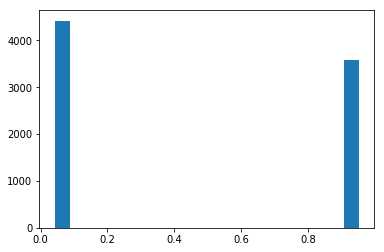

In [262]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [263]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.954933,0.8676,0.954230,0.821200
1,0.500000,0.0012,0.600000,0.000619
2,0.444444,0.0018,0.416667,0.001031
3,0.453125,0.0064,0.483871,0.003093
4,0.500000,0.0028,0.666667,0.002062
5,0.352941,0.0017,0.444444,0.000825
6,0.687500,0.0016,0.700000,0.001444
7,0.357143,0.0014,0.166667,0.000206
8,0.500000,0.0024,0.250000,0.000619
9,0.450000,0.0020,0.692308,0.001856


In [264]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 8011 marginals


In [265]:
_ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.767
Neg. class accuracy: 0.674
Precision            0.338
Recall               0.767
F1                   0.469
----------------------------------------
TP: 23 | FP: 45 | TN: 93 | FN: 7



In [267]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_ind_bth_1,0,1.000000,0.154762,0.017857,23,45,7,93,0.690476,0.954990
LF_ind_neg_1,1,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.333333
LF_ind_neg_2,2,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.444444
LF_ind_neg_sec,3,0.053571,0.053571,0.000000,0,0,0,9,1.000000,0.647059
LF_ind_pos_1,4,0.011905,0.011905,0.000000,2,0,0,0,1.000000,0.466667
LF_ind_pos_10,5,0.011905,0.011905,0.000000,1,1,0,0,0.500000,0.400000
LF_ind_pos_11,6,0.029762,0.029762,0.000000,5,0,0,0,1.000000,0.600000
LF_ind_pos_12,7,0.011905,0.011905,0.011905,2,0,0,0,1.000000,0.200000
LF_ind_pos_13,8,0.017857,0.017857,0.000000,0,3,0,0,0.000000,0.214286
LF_ind_pos_2,9,0.000000,0.000000,0.000000,0,0,0,0,NaN,0.642857
